# Import Packages

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from utils.rfe import model_rfe
from utils.model import model_combinations
from utils.model import stacking_model
from utils.plot import plot_roc_curve

# Load Data

In [22]:
# Read data from a tab-separated values (TSV) file into a DataFrame
df_all = pd.read_csv('../data/data_ml_1.txt', sep='\t')
# for col in df_all.columns[1:]:
#         df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
# df_all.to_csv('../data/data_for_ml_ct.txt', sep='\t', index=False)
df_all['Gender'] = df_all['Gender'].astype('category')
# Generate all possible pairwise combinations of the categories "A", "B", "C", and "D"
from itertools import combinations
category = ["A", "B", "C", "D"]
category = list(combinations(category, 2))
print(category)

[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]


In [1]:
import pandas as pd

# 读取数据
df_all = pd.read_csv('../data/data_ml_1.txt', sep='\t')

# 找到 Gender 列的位置
gender_col_index = df_all.columns.get_loc('Gender')

# 对 Gender 列进行独热编码
df_all_encoded = pd.get_dummies(df_all, columns=['Gender'], prefix='Gender')

# 获取独热编码列
gender_dummies = [col for col in df_all_encoded.columns if col.startswith('Gender')]

# 调整列顺序，将独热编码列插入原来的位置
columns = list(df_all_encoded.columns)
for col in reversed(gender_dummies):
    columns.insert(gender_col_index, columns.pop(columns.index(col)))

# 重新排列 DataFrame 列顺序
df_all_encoded = df_all_encoded[columns]

# 保存为新的文件
df_all_encoded.to_csv('../data/data_ml_1_encoded.txt', sep='\t', index=False)

In [ ]:
df_all

# Single ROC

In [ ]:
from utils.plot import plot_roc_for_disease_pairs
plot_roc_for_disease_pairs('../data/data_for_ml_ct.txt', '../figure/CT/ROC/single_pdf', '../figure/CT/ROC/single_png')

# PCA

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from utils.plot import plot_pca_for_disease_groups
from utils.plot import plot_pls_da_for_disease_groups
# plot_pls_da_for_disease_groups('../data/data_for_ml_ct.txt', '../figure/CT/PCA')
plot_pca_for_disease_groups('../data/data_for_ml_ct.txt', '../figure/CT/PCA')

# model selection

In [18]:
from utils.model import model_evaluation
models = [
    # ['RandomForest', RandomForestClassifier(n_estimators=3000, max_depth=5)],
    ['XGBoost', XGBClassifier(n_estimators = 3000, max_depth = 5)],
    ['LightGBM', LGBMClassifier(n_estimators = 3000, max_depth = 5, verbose = -1)],
    #['CatBoost', CatBoostClassifier(verbose = False,iterations = 500, max_depth = 5)]
]
for i in category:
    Cat_A = i[0]
    Cat_B = i[1]
    print(f"---------------{Cat_A} vs {Cat_B}---------------")
    df = df_all[df_all['Disease'].isin([Cat_A, Cat_B])]

    X = df.drop("Disease",axis = 1)
    y = df['Disease']
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    shuffle_index = np.random.permutation(X.index)
    X = X.iloc[shuffle_index]
    y = y.iloc[shuffle_index]
    y = y.map({Cat_A: 0, Cat_B: 1})

    model_evaluation(model_list=models, X=X, y=y)
    

---------------A vs B---------------
Model XGBoost cross validation score is [0.59574468 0.65957447 0.65957447 0.56521739 0.65217391] with average 0.6264569842738205
Model XGBoost cross train-test AUC is 0.7399193548387097
Model LightGBM cross validation score is [0.61702128 0.68085106 0.68085106 0.65217391 0.63043478] with average 0.6522664199814986
Model LightGBM cross train-test AUC is 0.7137096774193549
---------------A vs C---------------
Model XGBoost cross validation score is [0.75675676 0.86486486 0.78378378 0.77777778 0.80555556] with average 0.7977477477477477
Model XGBoost cross train-test AUC is 0.9558823529411764
Model LightGBM cross validation score is [0.72972973 0.81081081 0.75675676 0.77777778 0.80555556] with average 0.7761261261261261
Model LightGBM cross train-test AUC is 0.9147058823529411
---------------A vs D---------------
Model XGBoost cross validation score is [0.83333333 0.87234043 0.80851064 0.89361702 0.91489362] with average 0.8645390070921988
Model XGBoos

# Core

In [3]:
# Initialize the base model for feature selection
cores = [
    # ['RandomForest', RandomForestClassifier(n_estimators=3000, max_depth=5)],
    # ['XGBoost', XGBClassifier(n_estimators = 1000, max_depth = 5)],
    ['LightGBM', LGBMClassifier(n_estimators = 1000, max_depth = 10, verbose = -1)]#,
    # ['CatBoost', CatBoostClassifier(verbose = False,iterations = 300, max_depth = 5)]
]

In [ ]:
our_feature_combinations = {
                "A vs B": ['L1', 'L4', 'L5', 'S1', 'L1-L2_3', 'L2-L3_2', 'L2-L3_6', 'L3-L4_2', 'L4-L5_1', 'L4-L5_3'],
                "A vs C": ['L1', 'L4', 'L1-L2_3', 'L2-L3_4', 'L2-L3_5', 'L3-L4_1', 'L4-L5_1', 'L5-S1_4'],
                "A vs D": ['L1', 'L2', 'L4', 'L5', 'L1-L2_3', 'L1-L2_4', 'L1-L2_6', 'L2-L3_3', 'L2-L3_5', 'L3-L4_5', 'L4-L5_1', 'L4-L5_3', 'L4-L5_4', 'L4-L5_5'],
                "B vs C": ['L3', 'L5', 'S1', 'L1-L2_1', 'L1-L2_6', 'L2-L3_3', 'L2-L3_6', 'L3-L4_2', 'L3-L4_3', 'L4-L5_2', 'L4-L5_3', 'L4-L5_4', 'L4-L5_5'],
                "B vs D": ['L1', 'L5', 'S1', 'L1-L2_5', 'L1-L2_6', 'L2-L3_1', 'L2-L3_2', 'L2-L3_3', 'L2-L3_6', 'L3-L4_1', 'L3-L4_6', 'L4-L5_1', 'L4-L5_3'],
                "C vs D": ['L1', 'L2', 'L5', 'S1', 'L1-L2_2', 'L1-L2_3', 'L1-L2_4', 'L1-L2_6', 'L2-L3_2', 'L2-L3_3', 'L2-L3_4', 'L3-L4_1', 'L3-L4_2', 'L3-L4_3', 'L3-L4_6', 'L4-L5_2', 'L4-L5_5', 'L5-S1_1', 'L5-S1_4']
            }

In [ ]:
[0.55790934320074, 0.5449583718778908, 0.6559666975023126, 0.6265494912118409, 0.652081406105458, 0.6481961147086032, 0.6955596669750232, 0.7296022201665124, 0.720814061054579, 0.7381128584643848, 0.724976873265495, 0.7038852913968549, 0.7252543940795559, 0.7167437557816836, 0.708140610545791, 0.6994449583718779, 0.7167437557816837, 0.6954671600370027, 0.7081406105457908, 0.6824236817761331, 0.6952821461609621, 0.6824236817761332, 0.6821461609620721, 0.6524514338575392, 0.6652173913043479, 0.6438482886216466, 0.648196114708603, 0.669472710453284, 0.6607770582793709, 0.6567067530064754, 0.678168362627197, 0.6611470860314523, 0.6611470860314523, 0.6611470860314523, 0.6611470860314523, 0.6611470860314523]
[0.5735735735735736, 0.5515015015015015, 0.7487987987987987, 0.7702702702702704, 0.7809309309309309, 0.7704204204204205, 0.7647147147147146, 0.8468468468468469, 0.8193693693693694, 0.813963963963964, 0.814114114114114, 0.7980480480480481, 0.7867867867867868, 0.8084084084084084, 0.8193693693693694, 0.824924924924925, 0.7975975975975975, 0.792042042042042, 0.8088588588588589, 0.814114114114114, 0.8033033033033034, 0.8142642642642641, 0.7977477477477477, 0.7975975975975976, 0.8195195195195195, 0.8085585585585585, 0.803153153153153, 0.8033033033033032, 0.7866366366366366, 0.8033033033033032, 0.7866366366366367, 0.7867867867867868, 0.7867867867867868, 0.7867867867867868, 0.7867867867867868, 0.7867867867867868]
[0.538386524822695, 0.5976063829787235, 0.6693262411347518, 0.85177304964539, 0.8390070921985815, 0.8900709219858157, 0.8857269503546099, 0.8857269503546099, 0.8773936170212766, 0.890159574468085, 0.8814716312056738, 0.8813829787234043, 0.8813829787234042, 0.8941489361702126, 0.872872340425532, 0.8856382978723405, 0.8687056737588653, 0.8814716312056738, 0.8772163120567378, 0.8772163120567376, 0.8772163120567376, 0.8602836879432625, 0.8814716312056736, 0.8645390070921986, 0.8603723404255319, 0.8687943262411346, 0.8560283687943263, 0.8561170212765958, 0.8645390070921988, 0.8645390070921988, 0.8645390070921988, 0.8645390070921988, 0.8602836879432625, 0.8602836879432625, 0.8602836879432625, 0.8602836879432625]
[0.5860627177700348, 0.5527293844367015, 0.6159117305458769, 0.6011614401858305, 0.6108013937282231, 0.5626016260162602, 0.6440185830429732, 0.629732868757259, 0.653890824622532, 0.6439024390243903, 0.6491289198606272, 0.6536585365853659, 0.6826945412311265, 0.6587688734030197, 0.6585365853658537, 0.6344947735191637, 0.6534262485481998, 0.6440185830429732, 0.6488966318234611, 0.6441347270615564, 0.6540069686411151, 0.6249709639953542, 0.6492450638792102, 0.6347270615563299, 0.629849012775842, 0.61068524970964, 0.629849012775842, 0.6059233449477353, 0.6104529616724739, 0.6056910569105691, 0.6055749128919861, 0.586411149825784, 0.586411149825784, 0.586411149825784, 0.586411149825784, 0.586411149825784]
[0.5170537010159653, 0.5783744557329463, 0.6169085631349782, 0.635921625544267, 0.6322931785195935, 0.6976777939042089, 0.716545718432511, 0.7051523947750363, 0.7127721335268505, 0.7051523947750363, 0.7545718432510886, 0.7546444121915821, 0.7622641509433963, 0.7585631349782294, 0.743178519593614, 0.7164731494920175, 0.7277213352685052, 0.728011611030479, 0.7163280116110304, 0.7126995645863572, 0.6935413642960813, 0.689622641509434, 0.6973149492017416, 0.6972423802612482, 0.7009433962264151, 0.7203193033381713, 0.6818577648766329, 0.7050072568940494, 0.6858490566037736, 0.6936139332365748, 0.7088534107402034, 0.7089259796806967, 0.7050072568940493, 0.7088534107402034, 0.7050072568940493, 0.7050072568940493]
[0.5922480620155038, 0.5822812846068659, 0.6065337763012182, 0.5831672203765227, 0.6496124031007752, 0.6774086378737542, 0.6589147286821705, 0.6874861572535991, 0.6875968992248062, 0.6968992248062016, 0.6970099667774087, 0.7015503875968992, 0.7157253599114065, 0.6918050941306755, 0.701439645625692, 0.706312292358804, 0.6968992248062016, 0.7299003322259137, 0.7534883720930233, 0.7299003322259136, 0.7394241417497233, 0.7060908084163897, 0.7155038759689922, 0.7249169435215947, 0.7062015503875969, 0.6871539313399778, 0.6776301218161682, 0.6871539313399778, 0.7108527131782945, 0.6780730897009966, 0.6732004429678848, 0.6825027685492802, 0.6826135105204874, 0.6826135105204872, 0.6826135105204872, 0.6826135105204872]

# Machine Learning Process

In [4]:
# Suppress warnings from the output
df_all = df_all_encoded
import warnings
warnings.filterwarnings('ignore')
category = [("B","C")]
for m in cores:
    name = m[0]
    core = m[1]
    feature_combinations = []
    print(f"====================current core {name}====================")
    # Open a file for writing output logs
    f = open(f"../data/ml_process_ct_{name}_try.txt", "w")
    # Loop over each pairwise category combination
    for i in category:
        Cat_A = i[0]
        Cat_B = i[1]

        all_com = model_combinations()
        FPR = []
        TPR = []
        AUCs = []
        Scores = []
        
        print(f"---------------{Cat_A} vs {Cat_B}---------------")
        print("...Best Feature Combination Detecting...")
        f.write("--------------------" + str(Cat_A) + " and " + str(Cat_B) + "--------------------\n")
        
        # Filter the DataFrame to include only rows corresponding to the current categories
        df = df_all[df_all['Disease'].isin([Cat_A, Cat_B])]
        
        # Perform Recursive Feature Elimination (RFE) to find the best features
        best = model_rfe(f, core, df, Cat_A, Cat_B)
        feature_combinations.append(best)
        # print("...Stacking model is building...")

        # # Loop over each model combination and evaluate the performance
        # for m in tqdm(all_com):
        #     # Build the stacking model using the best features and current model combination
        #     IntegratedScore = stacking_model(df[best], df['Disease'].map({Cat_A: 0, Cat_B: 1}), list(m))
        #     Scores.append(IntegratedScore)
        #     # Compute ROC curve and AUC for the stacking model
        #     fpr, tpr, thresholds = roc_curve(IntegratedScore.iloc[:, 0], IntegratedScore.iloc[:, 1])
        #     roc_auc = auc(fpr, tpr)
            
        #     # Log the model details and performance
        #     f.write("Stacking Model: " + str([i[0] for i in m]) + "\n")
        #     f.write("ROC_AUC: " + str(roc_auc) + "\n")
        #     AUCs.append(roc_auc)
        #     FPR.append(fpr)
        #     TPR.append(tpr)
        
        # Identify the best stacking model based on the highest AUC
        # best_stacking = []
        # for t in all_com[AUCs.index(max(AUCs))]:
        #     best_stacking.append(t[0])
        
        # # Plot ROC curves save files
        # best_fpr = FPR[AUCs.index(max(AUCs))]
        # best_tpr = TPR[AUCs.index(max(AUCs))]
        # Scores[AUCs.index(max(AUCs))].to_csv(f"../data/predict/{Cat_A}_{Cat_B}.txt", sep='\t',index=False)
        # plot_roc_curve(best_fpr, best_tpr, max(AUCs), f"../figure/CT/ROC/ROC Plot of {Cat_A} VS {Cat_B}_2")

        # # Log the best stacking model and its AUC
        # f.write("Best Stacking Model detected " + str(best_stacking) + "\n")
        # f.write("Best IntegratedScore AUC = " + str(max(AUCs)) + "\n")
        # print("Best Stacking Model detected " + str(best_stacking))
        # print("Best IntegratedScore AUC = " + str(max(AUCs)))

    # Close the log file
    f.close()

====================current core LightGBM====================
---------------B vs C---------------
...Best Feature Combination Detecting...


100%|██████████| 39/39 [06:39<00:00, 10.24s/it]

Best Features Combination Detected: ['Age', 'L3', 'L4', 'S1', 'L1-L2_1', 'L1-L2_5', 'L1-L2_6', 'L2-L3_3', 'L2-L3_6', 'L3-L4_2', 'L3-L4_3', 'L4-L5_2', 'L4-L5_3', 'L4-L5_4', 'L4-L5_5']
Best Validation Score: 0.6684088269454124


# Score visualizing

/var/folders/12/n4s7mbz93hsbs7qt91pp0v3w0000gn/T/ipykernel_70293/2539605368.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(files))


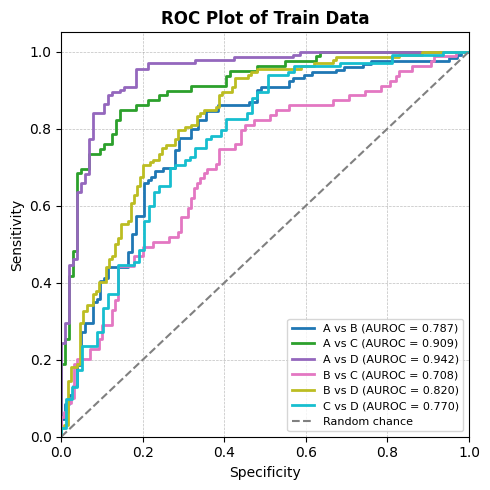

ROC plot saved to ../figure/CT/ROC_train.pdf


In [23]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
data_path = "../data/Predict"
files = ['A vs B.txt', 'A vs C.txt', 'A vs D.txt', 'B vs C.txt', 'B vs D.txt', 'C vs D.txt']
colors = plt.cm.get_cmap('tab10', len(files))
plt.figure(figsize=(5, 5))
for idx, file in enumerate(files):
    file_path = os.path.join(data_path, file)
    data = pd.read_csv(file_path, sep='\t', header=None)
    fpr, tpr, thresholds = roc_curve(data.iloc[:, 0], data.iloc[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors(idx), lw=2, label=f"{file.removesuffix('.txt')} (AUROC = {roc_auc:.3f})")
    plt.fill_between(fpr, tpr, color=colors(idx), alpha=0)
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity', fontsize=10)
plt.ylabel('Sensitivity', fontsize=10)
plt.title('ROC Plot of Train Data',fontweight='bold')
plt.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
output_path = "../figure/CT/ROC_train.pdf"
plt.savefig(output_path)
plt.show()
plt.close()
print(f"ROC plot saved to {output_path}")

In [4]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 创建一个存储结果的字典
metrics_dict = {'File': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []}

plt.figure(figsize=(10, 5))
for idx, file in enumerate(files):
    data = pd.read_csv(os.path.join(data_path, file), sep='\t', header=None)
    
    # 提取标签和预测值
    y_true = data.iloc[:, 0]
    y_pred = data.iloc[:, 1]
    accuracy = accuracy_score(y_true, y_pred.round())
    precision = precision_score(y_true, y_pred.round(), zero_division=0)
    recall = recall_score(y_true, y_pred.round())
    f1 = f1_score(y_true, y_pred.round())

    metrics_dict['File'].append(file.removesuffix('.txt'))
    metrics_dict['Accuracy'].append(accuracy)
    metrics_dict['Precision'].append(precision)
    metrics_dict['Recall'].append(recall)
    metrics_dict['F1'].append(f1)

# 输出计算的指标
metrics_df = pd.DataFrame(metrics_dict)
print(metrics_df)


     File  Accuracy  Precision    Recall        F1
0  A vs B  0.738197   0.732877  0.829457  0.778182
1  A vs C  0.841530   0.828947  0.797468  0.812903
2  A vs D  0.877119   0.870504  0.916667  0.892989
3  B vs C  0.629808   0.583333  0.088608  0.153846
4  B vs D  0.739464   0.742424  0.742424  0.742424
5  C vs D  0.767773   0.764331  0.909091  0.830450


<Figure size 1000x500 with 0 Axes>

0.7938870799915488
0.8780229498530308
0.9231458086549925
0.53135100169724
0.7795917824273834
0.8344306585956672


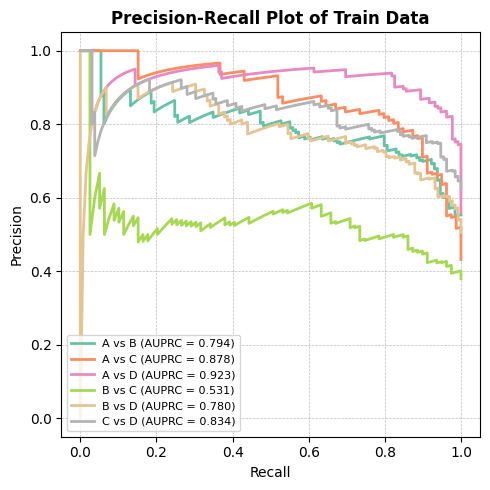

In [5]:
from sklearn.metrics import precision_recall_curve, auc
plt.figure(figsize=(5, 5))
for idx, file in enumerate(files):
    data = pd.read_csv(os.path.join(data_path, file), sep='\t', header=None)
    precision, recall, _ = precision_recall_curve(data.iloc[:, 0], data.iloc[:, 1])
    auprc = auc(recall, precision)  # 计算 AUPRC
    print(auprc)
    plt.plot(recall, precision, color=colors(idx), lw=2, label=f"{file.removesuffix('.txt')} (AUPRC = {auprc:.3f})")
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Plot of Train Data',fontweight='bold')
plt.legend(loc="lower left", fontsize=8)
plt.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)
plt.tight_layout()
plt.savefig("../figure/CT/PR_train.pdf")
plt.show()
plt.close()


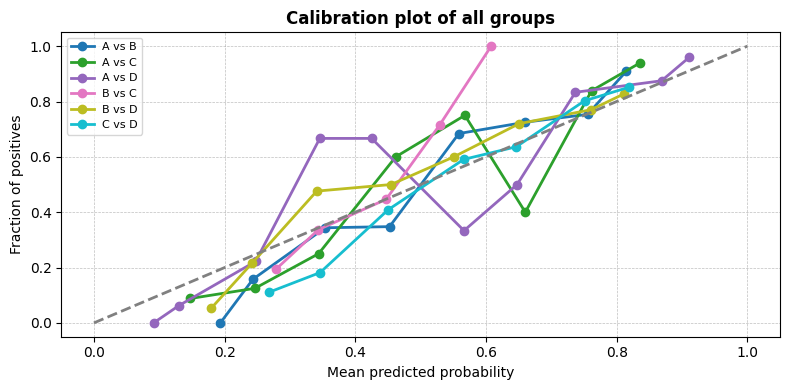

In [32]:
from sklearn.calibration import calibration_curve
plt.figure(figsize=(8, 4))
for idx, file in enumerate(files):
    data = pd.read_csv(os.path.join(data_path, file), sep='\t', header=None)
    prob_true, prob_pred = calibration_curve(data.iloc[:, 0], data.iloc[:, 1], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', color=colors(idx), label=f"{file.removesuffix('.txt')}", linewidth = 2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth = 2)
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot of all groups',fontweight='bold')
plt.legend(loc="upper left", fontsize=8)
plt.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)
plt.tight_layout()
plt.savefig("../figure/CT/Calibration_all.pdf")
plt.show()
plt.close()

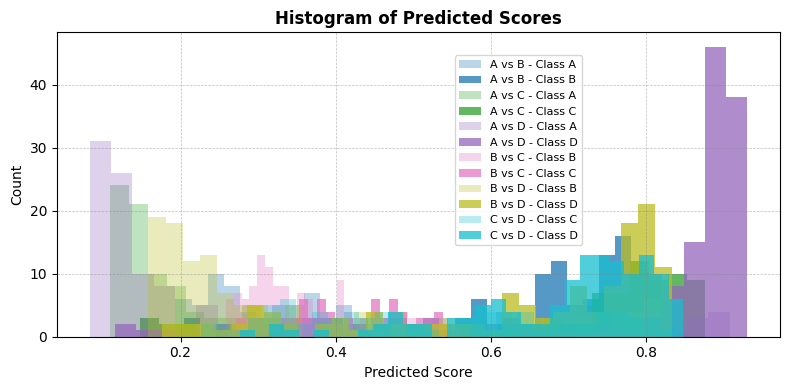

In [33]:
import seaborn as sns
plt.figure(figsize=(8, 4))
for idx, file in enumerate(files):
    data = pd.read_csv(os.path.join(data_path, file), sep='\t', header=None)
    plt.hist(data.iloc[:, 1][data.iloc[:, 0] == 0], bins=30, alpha=0.3, color=colors(idx), density=False, label=f"{file.removesuffix('.txt')} - Class {file.removesuffix('.txt').split(' vs ')[0]}")
    plt.hist(data.iloc[:, 1][data.iloc[:, 0] == 1], bins=30, alpha=0.75, color=colors(idx), density=False, label=f"{file.removesuffix('.txt')} - Class {file.removesuffix('.txt').split(' vs ')[1]}")
plt.xlabel('Predicted Score')
plt.ylabel('Count')
plt.title('Histogram of Predicted Scores',fontweight='bold')
plt.legend(loc=[0.55, 0.3], fontsize=8)
plt.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)
plt.tight_layout()
plt.savefig("../figure/CT/Histogram_all.pdf")
plt.show()
plt.close()

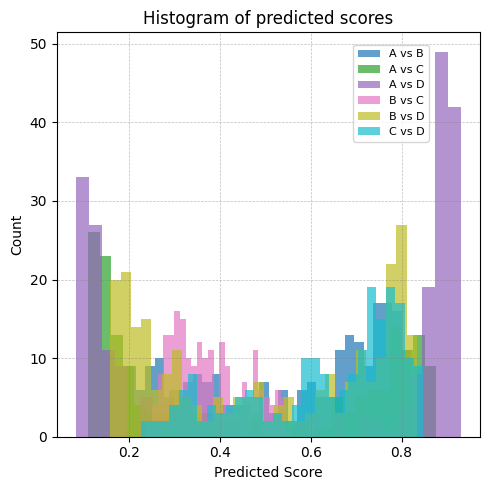

In [21]:
plt.figure(figsize=(5, 5))
for idx, file in enumerate(files):
    data = pd.read_csv(os.path.join(data_path, file), sep='\t', header=None)
    plt.hist(data.iloc[:, 1], bins=30, color=colors(idx), alpha=0.7, label=file.removesuffix('.txt'))
plt.xlabel('Predicted Score')
plt.ylabel('Count')
plt.title('Histogram of predicted scores')
plt.legend(loc=[0.7, 0.73], fontsize=8)
plt.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)
plt.tight_layout()
plt.savefig("../figure/CT/Histogram_all.pdf")
plt.show()
plt.close()

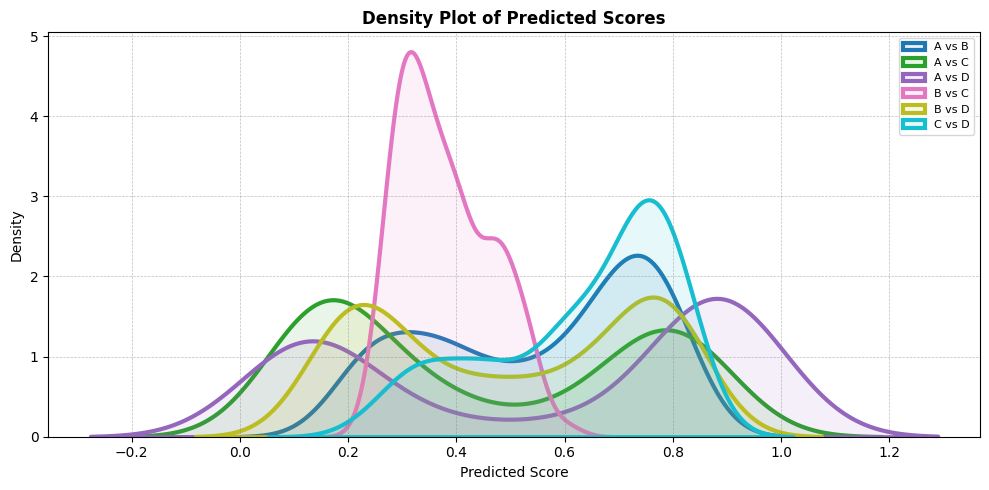

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


plt.figure(figsize=(10, 5))
for idx, file in enumerate(files):
    data = pd.read_csv(os.path.join(data_path, file), sep='\t', header=None)
    
    sns.kdeplot(
        data.iloc[:, 1],
        color=colors(idx),
        fill=True,
        alpha=0.1,
        linewidth=3,
        # clip=(0, 1),  # 限制密度估计的范围在 0-1 之间
        label=file.removesuffix('.txt')
    )

plt.xlabel('Predicted Score')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Scores', fontweight='bold')
# plt.xlim(0, 1)  # 手动设置 x 轴范围
plt.legend(loc='upper right', fontsize=8)
plt.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)
plt.tight_layout()
plt.savefig("../figure/CT/Density_all.pdf")
plt.show()
plt.close()


# SHAP Explanation

## selected features

In [3]:
feature_combinations = [
    ['L1', 'L4', 'L5', 'S1', 'L1-L2_3', 'L2-L3_2', 'L2-L3_6', 'L3-L4_2', 'L4-L5_1', 'L4-L5_3'],
    ['L1', 'L4', 'L1-L2_3', 'L2-L3_4', 'L2-L3_5', 'L3-L4_1', 'L4-L5_1', 'L5-S1_4'],
    ['L1', 'L2', 'L4', 'L5', 'L1-L2_3', 'L1-L2_4', 'L1-L2_6', 'L2-L3_3', 'L2-L3_5', 'L3-L4_5', 'L4-L5_1', 'L4-L5_3', 'L4-L5_4', 'L4-L5_5'],
    ['L3', 'L5', 'S1', 'L1-L2_1', 'L1-L2_6', 'L2-L3_3', 'L2-L3_6', 'L3-L4_2', 'L3-L4_3', 'L4-L5_2', 'L4-L5_3', 'L4-L5_4', 'L4-L5_5'],
    ['L1', 'L5', 'S1', 'L1-L2_5', 'L1-L2_6', 'L2-L3_1', 'L2-L3_2', 'L2-L3_3', 'L2-L3_6', 'L3-L4_1', 'L3-L4_6', 'L4-L5_1', 'L4-L5_3'],
    ['L1', 'L2', 'L5', 'S1', 'L1-L2_2', 'L1-L2_3', 'L1-L2_4', 'L1-L2_6', 'L2-L3_2', 'L2-L3_3', 'L2-L3_4', 'L3-L4_1', 'L3-L4_2', 'L3-L4_3', 'L3-L4_6', 'L4-L5_2', 'L4-L5_5', 'L5-S1_1', 'L5-S1_4']
]

## basic plots

In [4]:
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap

category = ["A", "B", "C", "D"]
category = list(combinations(category, 2))
for i in range(len(category)):
    Cat_A = category[i][0]
    Cat_B = category[i][1]
    df = df_all[df_all['Disease'].isin([Cat_A, Cat_B])]
    X = df.drop("Disease",axis = 1)
    X = X[feature_combinations[i]]
    y = df['Disease']
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    shuffle_index = np.random.permutation(X.index)
    X = X.iloc[shuffle_index]
    y = y.iloc[shuffle_index]
    y = y.map({Cat_A: 0, Cat_B: 1})

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    d_train = lgb.Dataset(X_train, label=y_train)
    d_test = lgb.Dataset(X_test, label=y_test)

    params = {
        "max_bin": 512,
        "learning_rate": 0.05,
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "binary_logloss",
        "num_leaves": 10,
        "verbose": -1,
        "boost_from_average": True,
        "early_stopping_rounds": 50,
        "verbose_eval": 1000
    }

    model = lgb.train(
        params,
        d_train,
        1000,
        valid_sets=[d_test],
    )
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    # Save force plot
    # p = shap.plots.force(explainer.expected_value,shap_values.values,shap_values.data)
    # shap.save_html(f'../figure/CT/Exp/{category[i][0]}_vs_{category[i][1]}.html', p)

    # Save summary plot
    fig = shap.plots.beeswarm(shap_values, show=False, alpha=0.7)
    plt.title(f"{category[i][0]} vs {category[i][1]}", fontweight='bold', fontsize=10)
    plt.xlabel("Impact on model output")
    plt.tight_layout()
    plt.savefig(f"../figure/CT/Exp/{category[i][0]}_vs_{category[i][1]}.pdf", bbox_inches='tight')
    plt.close()

    fig = shap.plots.heatmap(shap_values, show=False)
    plt.title(f"{category[i][0]} vs {category[i][1]}", fontweight='bold', fontsize=10)
    plt.tight_layout()
    plt.savefig(f"../figure/CT/Exp/{category[i][0]}_vs_{category[i][1]}_heat.pdf", bbox_inches='tight')
    plt.close()
    
    start_color = (1, 0, 0)  # red
    middle_color = (1, 0.843, 0)  # gold
    end_color = (0, 0.392, 0)
    cmap = LinearSegmentedColormap.from_list("custom_cmap", [start_color, middle_color, end_color], N=1000)

    for m in tqdm(X.columns.to_list()):
        fig, ax = plt.subplots(tight_layout=True, figsize=(6,4))
        plt.title(f"{category[i][0]} vs {category[i][1]} feature {m} dependence", fontweight='bold', fontsize=10)
        ax.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)
        shap.plots.scatter(shap_values[:, f"{m}"], color=shap_values, cmap=cmap, ax=ax, show = False)
        plt.savefig(f"../figure/CT/Exp/Dependence/{category[i][0]}_vs_{category[i][1]}_{m}.pdf", bbox_inches='tight')
        plt.close()

### Cen

In [73]:
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
Cat_A = "A"
Cat_B = "C"
f = ['L1', 'L4', 'L1-L2_3', 'L2-L3_4', 'L2-L3_5', 'L3-L4_1', 'L4-L5_1', 'L5-S1_4']
df = df_all[df_all['Disease'].isin([Cat_A, Cat_B])]
X = df.drop("Disease",axis = 1)
X = X[f]
y = df['Disease']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
shuffle_index = np.random.permutation(X.index)
X = X.iloc[shuffle_index]
y = y.iloc[shuffle_index]
y = y.map({Cat_A: 0, Cat_B: 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "boost_from_average": True,
    "early_stopping_rounds": 50,
    "verbose_eval": 1000
}
model = lgb.train(
    params,
    d_train,
    1000,
    valid_sets=[d_test],
)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
start_color = (0.2, 0.8, 0.2)
middle_color = (1, 1, 0)
end_color = (1, 0, 0)
cmap = plt.get_cmap('RdYlBu_r',12)

fig, ax = plt.subplots(figsize=(5, 4))
plt.title("L4 & L1 Dependence Plot", fontweight='bold', fontsize=10)
ax.grid(linestyle="--", color="gray", linewidth=0.3, zorder=0, alpha=0.3)
shap.plots.scatter(shap_values[:, "L4"], color=shap_values[:, "L1"], cmap=cmap, ax=ax, show=False, dot_size = 25)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
plt.savefig(f"../figure/CT/Exp/Dependence/L4 & L1 Dependence Plot.pdf", bbox_inches='tight')
plt.close()

In [83]:
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
Cat_A = "B"
Cat_B = "D"
f = ['L1', 'L5', 'S1', 'L1-L2_5', 'L1-L2_6', 'L2-L3_1', 'L2-L3_2', 'L2-L3_3', 'L2-L3_6', 'L3-L4_1', 'L3-L4_6', 'L4-L5_1', 'L4-L5_3']
df = df_all[df_all['Disease'].isin([Cat_A, Cat_B])]
X = df.drop("Disease",axis = 1)
X = X[f]
y = df['Disease']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
shuffle_index = np.random.permutation(X.index)
X = X.iloc[shuffle_index]
y = y.iloc[shuffle_index]
y = y.map({Cat_A: 0, Cat_B: 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "boost_from_average": True,
    "early_stopping_rounds": 50,
    "verbose_eval": 1000
}
model = lgb.train(
    params,
    d_train,
    1000,
    valid_sets=[d_test],
)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
start_color = (0.2, 0.8, 0.2)
middle_color = (1, 1, 0)
end_color = (1, 0, 0)
cmap = plt.get_cmap('RdYlBu_r',12)

fig, ax = plt.subplots(figsize=(5, 4))
plt.title("S1 & L3 Dependence Plot", fontweight='bold', fontsize=10)
ax.grid(linestyle="--", color="gray", linewidth=0.3, zorder=0, alpha=0.3)
shap.plots.scatter(shap_values[:, "S1"], color=shap_values[:, "L3"], cmap=cmap, ax=ax, show=False, dot_size = 25)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
plt.savefig(f"../figure/CT/Exp/Dependence/L5 & L3 Dependence Plot.pdf", bbox_inches='tight')
plt.close()

In [75]:
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
Cat_A = "A"
Cat_B = "D"
f = ['L1', 'L2', 'L4', 'L5', 'L1-L2_3', 'L1-L2_4', 'L1-L2_6', 'L2-L3_3', 'L2-L3_5', 'L3-L4_5', 'L4-L5_1', 'L4-L5_3', 'L4-L5_4', 'L4-L5_5']
df = df_all[df_all['Disease'].isin([Cat_A, Cat_B])]
X = df.drop("Disease",axis = 1)
X = X[f]
y = df['Disease']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
shuffle_index = np.random.permutation(X.index)
X = X.iloc[shuffle_index]
y = y.iloc[shuffle_index]
y = y.map({Cat_A: 0, Cat_B: 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "boost_from_average": True,
    "early_stopping_rounds": 50,
    "verbose_eval": 1000
}
model = lgb.train(
    params,
    d_train,
    1000,
    valid_sets=[d_test],
)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
start_color = (0.2, 0.8, 0.2)
middle_color = (1, 1, 0)
end_color = (1, 0, 0)
cmap = plt.get_cmap('RdYlBu_r',12)

fig, ax = plt.subplots(figsize=(5, 4))
plt.title("L5 & L4 Dependence Plot", fontweight='bold', fontsize=10)
ax.grid(linestyle="--", color="gray", linewidth=0.3, zorder=0, alpha=0.3)
shap.plots.scatter(shap_values[:, "L5"], color=shap_values[:, "L4"], cmap=cmap, ax=ax, show=False, dot_size = 25)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
plt.savefig(f"../figure/CT/Exp/Dependence/L5 & L4 Dependence Plot.pdf", bbox_inches='tight')
plt.close()

### Muscle

In [94]:
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
Cat_A = "B"
Cat_B = "D"
f = ['L1', 'L5', 'S1', 'L1-L2_5', 'L1-L2_6', 'L2-L3_1', 'L2-L3_2', 'L2-L3_3', 'L2-L3_6', 'L3-L4_1', 'L3-L4_6', 'L4-L5_1', 'L4-L5_3']
df = df_all[df_all['Disease'].isin([Cat_A, Cat_B])]
X = df.drop("Disease",axis = 1)
X = X[f]
y = df['Disease']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
shuffle_index = np.random.permutation(X.index)
X = X.iloc[shuffle_index]
y = y.iloc[shuffle_index]
y = y.map({Cat_A: 0, Cat_B: 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "boost_from_average": True,
    "early_stopping_rounds": 50,
    "verbose_eval": 1000
}
model = lgb.train(
    params,
    d_train,
    1000,
    valid_sets=[d_test],
)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
start_color = (0.2, 0.8, 0.2)
middle_color = (1, 1, 0)
end_color = (1, 0, 0)
cmap = plt.get_cmap('RdYlBu_r',12)

fig, ax = plt.subplots(figsize=(5, 4))
plt.title("S1 & L1-L2_5 Dependence Plot", fontweight='bold', fontsize=10)
ax.grid(linestyle="--", color="gray", linewidth=0.3, zorder=0, alpha=0.3)
shap.plots.scatter(shap_values[:, "S1"], color=shap_values[:, "L1-L2_5"], cmap=cmap, ax=ax, show=False, dot_size = 25)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
plt.savefig(f"../figure/CT/Exp/Dependence/S1 & L1-L2_5 Dependence Plot.pdf", bbox_inches='tight')
plt.close()

In [93]:
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
Cat_A = "B"
Cat_B = "D"
f = ['L1', 'L5', 'S1', 'L1-L2_5', 'L1-L2_6', 'L2-L3_1', 'L2-L3_2', 'L2-L3_3', 'L2-L3_6', 'L3-L4_1', 'L3-L4_6', 'L4-L5_1', 'L4-L5_3']
df = df_all[df_all['Disease'].isin([Cat_A, Cat_B])]
X = df.drop("Disease",axis = 1)
X = X[f]
y = df['Disease']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
shuffle_index = np.random.permutation(X.index)
X = X.iloc[shuffle_index]
y = y.iloc[shuffle_index]
y = y.map({Cat_A: 0, Cat_B: 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "boost_from_average": True,
    "early_stopping_rounds": 50,
    "verbose_eval": 1000
}
model = lgb.train(
    params,
    d_train,
    1000,
    valid_sets=[d_test],
)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
start_color = (0.2, 0.8, 0.2)
middle_color = (1, 1, 0)
end_color = (1, 0, 0)
cmap = plt.get_cmap('RdYlBu_r',12)

fig, ax = plt.subplots(figsize=(5, 4))
plt.title("L5 & L3-L4_1 Dependence Plot", fontweight='bold', fontsize=10)
ax.grid(linestyle="--", color="gray", linewidth=0.3, zorder=0, alpha=0.3)
shap.plots.scatter(shap_values[:, "L5"], color=shap_values[:, "L3-L4_1"], cmap=cmap, ax=ax, show=False, dot_size = 25)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
plt.savefig(f"../figure/CT/Exp/Dependence/L5 & L3-L4_1 Dependence Plot.pdf", bbox_inches='tight')
plt.close()

In [81]:
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
Cat_A = "C"
Cat_B = "D"
f = ['L1', 'L2', 'L5', 'S1', 'L1-L2_2', 'L1-L2_3', 'L1-L2_4', 'L1-L2_6', 'L2-L3_2', 'L2-L3_3', 'L2-L3_4', 'L3-L4_1', 'L3-L4_2', 'L3-L4_3', 'L3-L4_6', 'L4-L5_2', 'L4-L5_5', 'L5-S1_1', 'L5-S1_4']
df = df_all[df_all['Disease'].isin([Cat_A, Cat_B])]
X = df.drop("Disease",axis = 1)
X = X[f]
y = df['Disease']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
shuffle_index = np.random.permutation(X.index)
X = X.iloc[shuffle_index]
y = y.iloc[shuffle_index]
y = y.map({Cat_A: 0, Cat_B: 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "boost_from_average": True,
    "early_stopping_rounds": 50,
    "verbose_eval": 1000
}
model = lgb.train(
    params,
    d_train,
    1000,
    valid_sets=[d_test],
)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
start_color = (0.2, 0.8, 0.2)
middle_color = (1, 1, 0)
end_color = (1, 0, 0)
cmap = plt.get_cmap('RdYlBu_r',12)

fig, ax = plt.subplots(figsize=(5, 4))
plt.title("L1-L2_2 & L1-L2_3 Dependence Plot", fontweight='bold', fontsize=10)
ax.grid(linestyle="--", color="gray", linewidth=0.3, zorder=0, alpha=0.3)
shap.plots.scatter(shap_values[:, "L1-L2_2"], color=shap_values[:, "L1-L2_3"], cmap=cmap, ax=ax, show=False, dot_size = 25)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
plt.savefig(f"../figure/CT/Exp/Dependence/L1-L2_2 & L1-L2_3 Dependence Plot.pdf", bbox_inches='tight')
plt.close()

## shap interaction values

In [30]:
import shap
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import networkx as nx

category = ["A", "B", "C", "D"]
category = list(combinations(category, 2))
Interactions = []
# Create a figure and set up the 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 22.5))
axs = axs.flatten()  # Flatten the 2D array of axes to easily index

for i in range(len(category)):
    Cat_A = category[i][0]
    Cat_B = category[i][1]
    df = df_all[df_all['Disease'].isin([Cat_A, Cat_B])]
    X = df.drop("Disease", axis=1)
    X = X[feature_combinations[i]]
    y = df['Disease']
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    shuffle_index = np.random.permutation(X.index)
    X = X.iloc[shuffle_index]
    y = y.iloc[shuffle_index]
    y = y.map({Cat_A: 0, Cat_B: 1})
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    d_train = lgb.Dataset(X_train, label=y_train)
    d_test = lgb.Dataset(X_test, label=y_test)
    params = {
        "max_bin": 512,
        "learning_rate": 0.05,
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "binary_logloss",
        "num_leaves": 10,
        "verbose": -1,
        "boost_from_average": True,
        "early_stopping_rounds": 50,
        "verbose_eval": 1000
    }
    model = lgb.train(
        params,
        d_train,
        1000,
        valid_sets=[d_test],
    )
    shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X)
    interaction_matrix = np.abs(shap_interaction_values).sum(0)
    for j in range(interaction_matrix.shape[0]):
        interaction_matrix[j, j] = 0
    inds = np.argsort(-interaction_matrix.sum(0))[:len(feature_combinations[i])]
    sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
    
    # Plot each heatmap in the corresponding subplot
    ax = axs[i]
    sns.heatmap(sorted_ia_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Intensity'}, cbar=False, ax=ax)
    ax.set_xticklabels(
        X.columns[inds],
        rotation=45,
        horizontalalignment="right"
    )
    ax.set_yticklabels(
        X.columns[inds],
        rotation=45,
        horizontalalignment="right"
    )
    ax.set_title(f"{category[i][0]} vs {category[i][1]}")
    # Construct
    feature_names = X.columns[inds]
    # Create a network graph
    G = nx.Graph()
    # Add nodes with feature names
    for feature in feature_names:
        G.add_node(feature)
    # Add edges with weights from the interaction matrix
    for row in range(sorted_ia_matrix.shape[0]):
        for col in range(row + 1, sorted_ia_matrix.shape[1]):
            weight = sorted_ia_matrix[row, col]
            if weight > 2:
                G.add_edge(feature_names[row], feature_names[col])
    Interactions.append(G)
# Adjust layout to prevent overlap
plt.tight_layout()
# Save the combined figure
plt.savefig("../figure/CT/Interaction2/combined_interaction_heatmaps.pdf", bbox_inches='tight')
plt.close()
print("Combined heatmap figure saved to ../figure/CT/Interaction2/combined_interaction_heatmaps.pdf")

Combined heatmap figure saved to ../figure/CT/Interaction2/combined_interaction_heatmaps.pdf


# Interact Network

1. The communication dependence of the muscles near the vertebral body on the vertebral body: the vertebral body acts as a bridge connecting muscles 1, 2, 4, and 5, with high centrality. The vertebrae played a key role in these muscle-to-muscle interactions, with vertebrae-muscle interactions being significantly stronger than muscle-muscle interactions, and interactions being strongly dependent on the vertebrae. So in this part the centrality of the vertebrae is high and the centrality of the muscles is relatively low.

2. Phased changes in the interaction pattern: From stage A to stage D of the disease, the interaction pattern gradually changed from a pattern dominated by vertebrae-muscle interaction to a pattern dominated by muscle-muscle interaction. This change reflects the gradual diminishment of the importance of the vertebral body in the early stages, while direct interaction between muscles becomes more prominent.

3. Importance of distal muscles: Distal muscles 3 and 6 are key muscle-muscle interaction nodes. Due to their greater spatial distance from the vertebrae, these two muscles are more difficult to communicate with through the efficient interactive network of the vertebrae than the other four muscles. Therefore, they play an important role in muscle-muscle interaction.

4. Importance of left-right communication: Muscles on the right side of the image (muscles 3, 2, 1) are of higher importance in communication than muscles on the left (muscles 6, 5, 4). Specifically, muscle 3 is more important than muscle 6, muscle 2 is more important than muscle 5, and muscle 1 is more important than muscle 4.

**The network can be roughly regarded as the vertebrae-dependent interaction module and the muscle-muscle interaction module, and the disease progression gradually changes from the proximal vertebrae-dependent interaction module to the distal muscle interaction module**

## Network based on shap dependence value

In [31]:
Graph_BMI = nx.compose_all(Interactions)
isolated_nodes = list(nx.isolates(Graph_BMI))
Graph_BMI.remove_nodes_from(isolated_nodes)
nx.write_graphml(Graph_BMI, '../data/network.graphml')

### Visualize

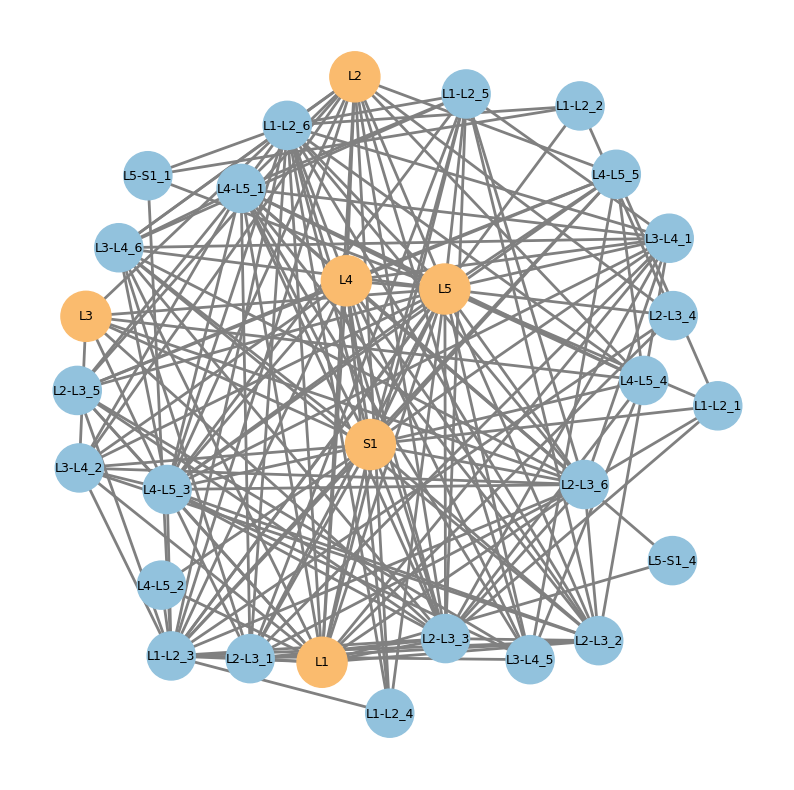

In [32]:
plt.figure(figsize=(10, 10))
plt.tight_layout()
node_colors = []
node_sizes = []
for node in Graph_BMI.nodes:
    if node in ['L1', 'L2', 'L3', 'L4', 'L5', 'S1']:
        node_colors.append('#FABB6E')
        node_sizes.append(1300)
    else:
        node_colors.append('#92C2DD')
        node_sizes.append(1200)
pos = nx.spring_layout(Graph_BMI, k=3)
# Draw nodes and edges
nx.draw_networkx_nodes(Graph_BMI, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(Graph_BMI, pos, edge_color='gray', width=2)
nx.draw_networkx_labels(Graph_BMI, pos, font_size=9, font_family='sans-serif')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Remove ticks
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.savefig('../figure/CT/Interaction2/Network.pdf')
plt.show()


### Adjacency Matrix Heatmap

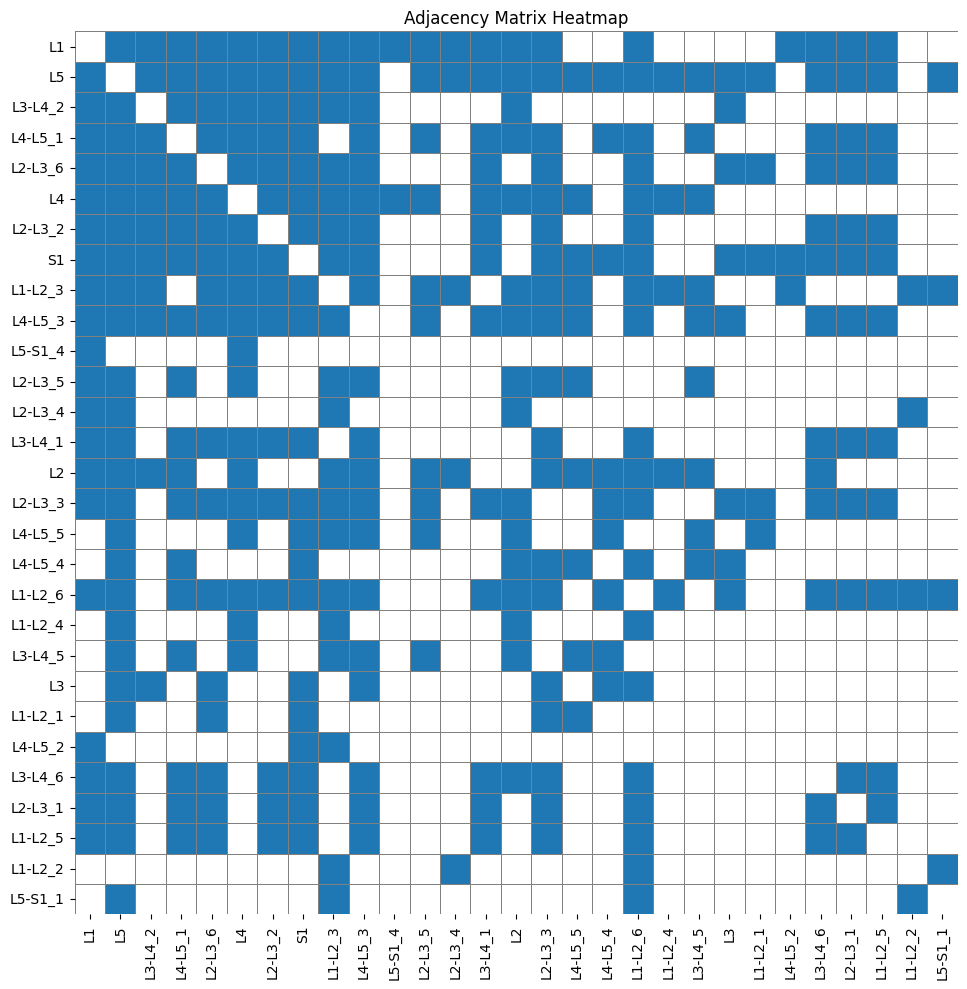

In [33]:
adj_matrix = nx.to_numpy_matrix(Graph_BMI)
# 设置无连接的节点为白色，有连接的节点为蓝色
adj_matrix = np.where(adj_matrix > 0, 1, 0)
# 绘制邻接矩阵热图，添加灰色网格线
plt.figure(figsize=(10, 10))
sns.heatmap(adj_matrix, cmap=sns.color_palette(['white', '#1f77b4']), annot=False, cbar=False, square=True,
            xticklabels=Graph_BMI.nodes(), yticklabels=Graph_BMI.nodes(), linewidths=0.7, linecolor='gray')
plt.title('Adjacency Matrix Heatmap')
plt.tight_layout()
plt.savefig('../figure/CT/Interaction2/Adj.pdf')
plt.show()

### Network Centrality

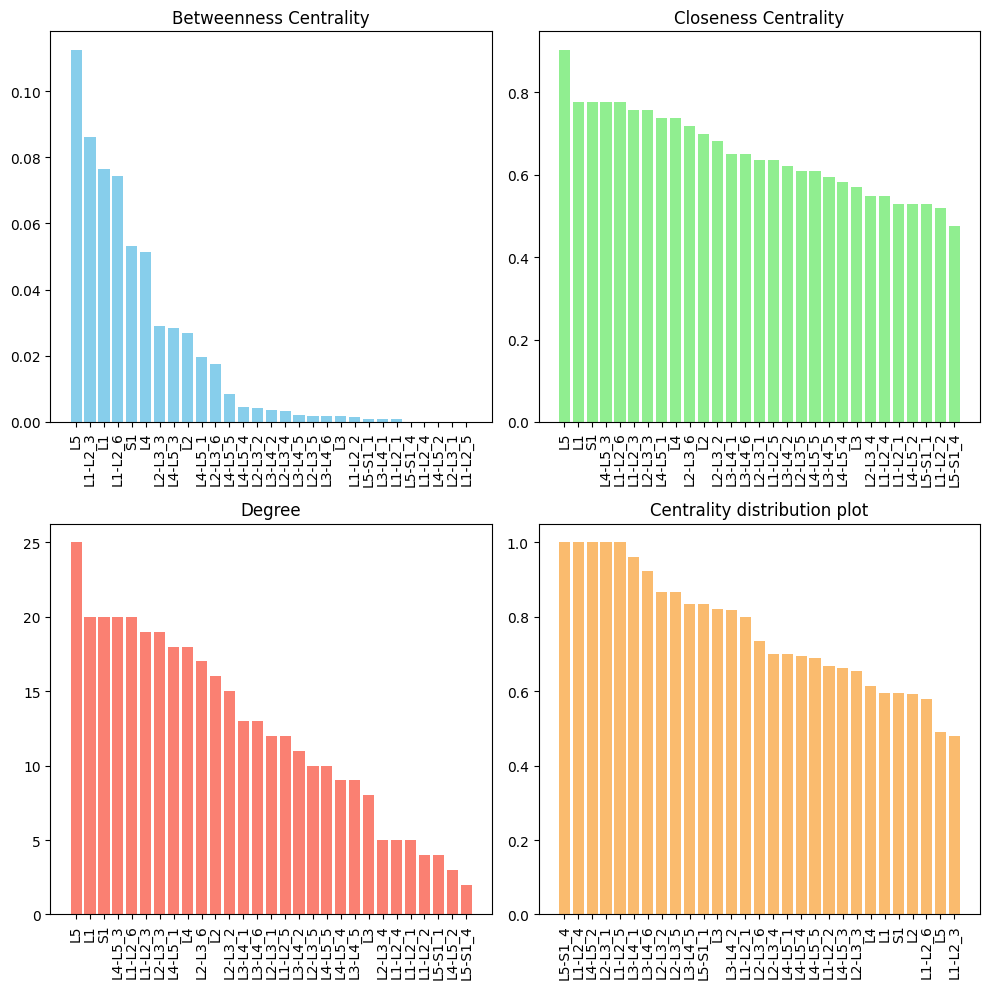

In [34]:
betweenness = nx.betweenness_centrality(Graph_BMI)
closeness = nx.closeness_centrality(Graph_BMI)
degree = dict(Graph_BMI.degree())
clustering = nx.clustering(Graph_BMI)
betweenness_sorted = dict(sorted(betweenness.items(), key=lambda item: item[1], reverse=True))
closeness_sorted = dict(sorted(closeness.items(), key=lambda item: item[1], reverse=True))
degree_sorted = dict(sorted(degree.items(), key=lambda item: item[1], reverse=True))
clustering_sorted = dict(sorted(clustering.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.bar(betweenness_sorted.keys(), betweenness_sorted.values(), color='skyblue')
plt.title('Betweenness Centrality')
plt.xticks(rotation=90)
plt.subplot(2, 2, 2)
plt.bar(closeness_sorted.keys(), closeness_sorted.values(), color='lightgreen')
plt.title('Closeness Centrality')
plt.xticks(rotation=90)
plt.subplot(2, 2, 3)
plt.bar(degree_sorted.keys(), degree_sorted.values(), color='salmon')
plt.title('Degree')
plt.xticks(rotation=90)
plt.subplot(2, 2, 4)
plt.bar(clustering_sorted.keys(), clustering_sorted.values(), color='#FABB6E')
plt.title('Clustering Coefficient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Centrality distribution plot')
plt.savefig('../figure/CT/Interaction2/Centrality.pdf')
plt.show()
plt.close()

### node clustering

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain
import numpy as np

for i in range(10):
    partition = community_louvain.best_partition(Graph_BMI)
    # Get unique community numbers
    communities = set(partition.values())
    num_communities = len(communities)
    # Define color map
    cmap = plt.get_cmap('Set2', num_communities)
    # Create a custom layout
    pos = nx.spring_layout(Graph_BMI, seed=42)
    # Draw the network with separated communities
    plt.figure(figsize=(12, 12))
    # Draw nodes with color based on community
    colors = [cmap(partition[node]) for node in Graph_BMI.nodes()]
    nx.draw_networkx_nodes(Graph_BMI, pos, node_size=2000, node_color=colors, edgecolors='black')
    # Draw edges
    nx.draw_networkx_edges(Graph_BMI, pos, edgelist=nx.edges(Graph_BMI), edge_color='gray', width=2)
    # Draw labels
    nx.draw_networkx_labels(Graph_BMI, pos, font_size=10, font_family='sans-serif')
    # Remove black border (spines)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Remove ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    plt.title('Network Clustering Visualization with Separated Communities')
    plt.savefig(f'../figure/CT/Interaction2/Clustering_{i+1}.pdf')
    # plt.show()


## Network based on dependency plot

Generating Interaction Network


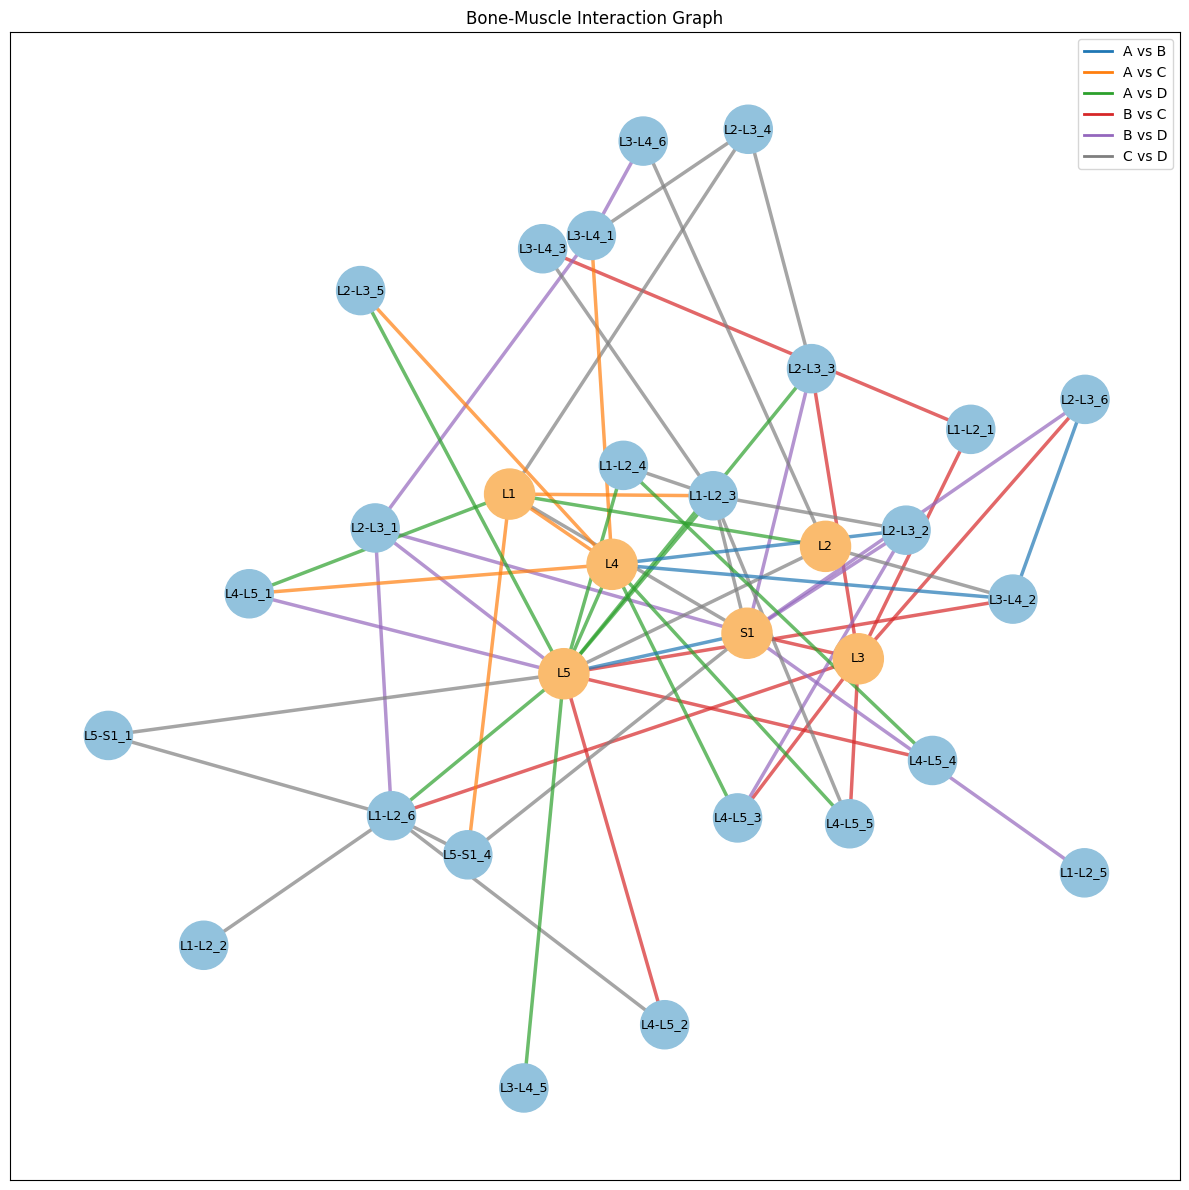

Graph saved as ../figure/CT/Interact_network.pdf


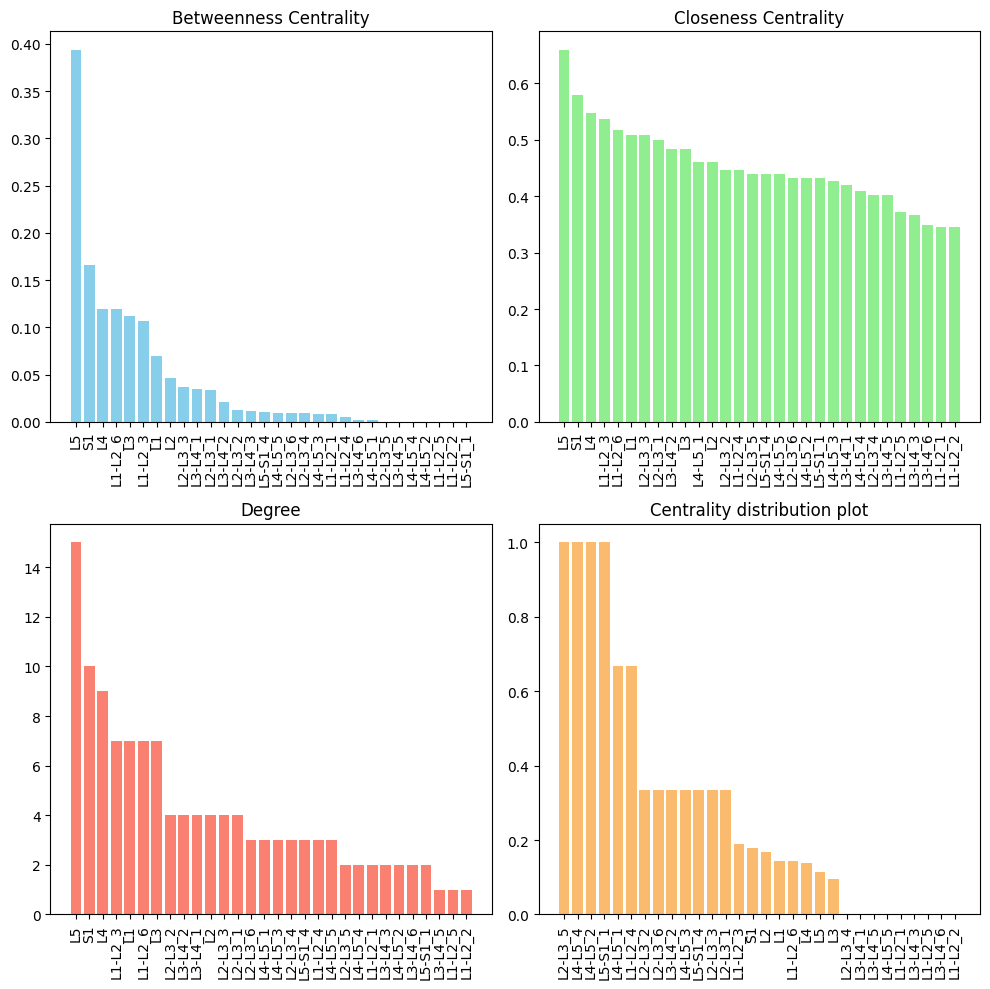

Centrality saved as ../figure/CT/Cen_statistics.pdf


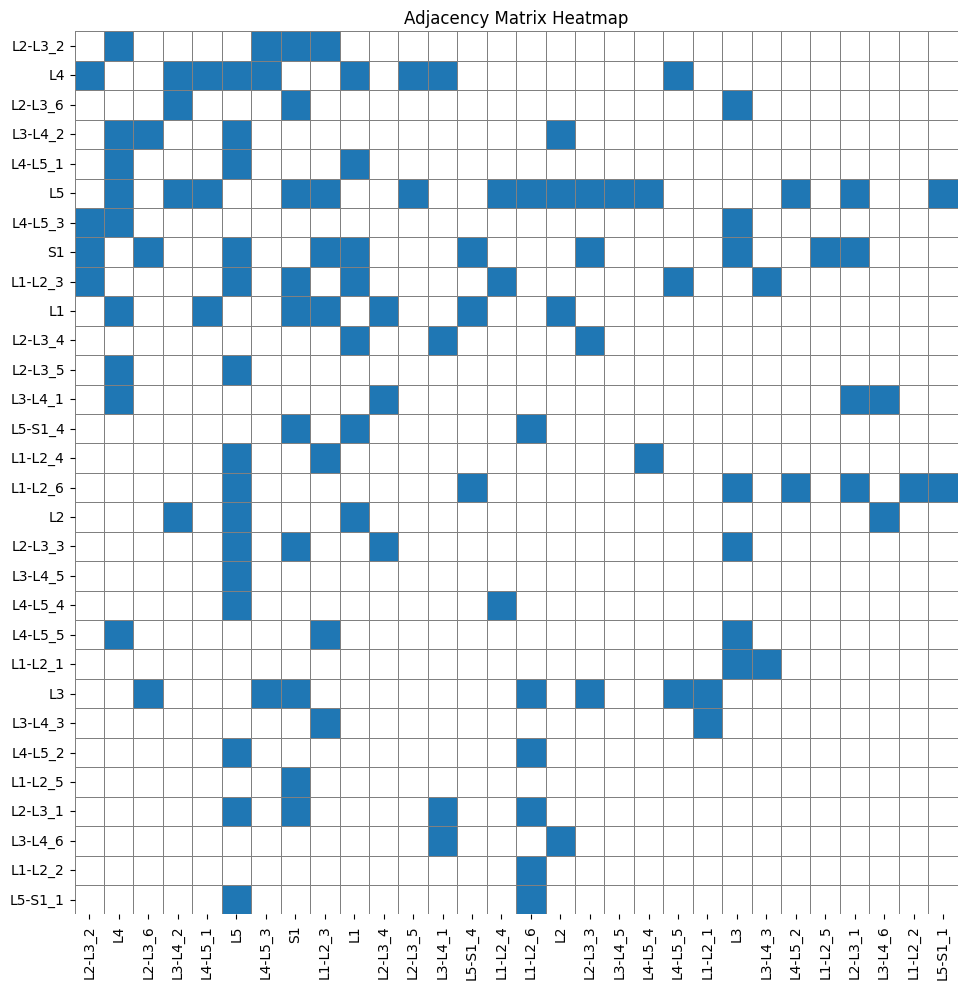

Adjacency Matrix Heatmap saved as ../figure/CT/adj_matrix.pdf


In [1]:
from utils.plot import plot_network
plot_network('../data/Interact.xlsx', '../figure/CT/Interact_network.pdf', '../figure/CT/Cen_statistics.pdf','../figure/CT/adj_matrix.pdf')

### Interacion mode

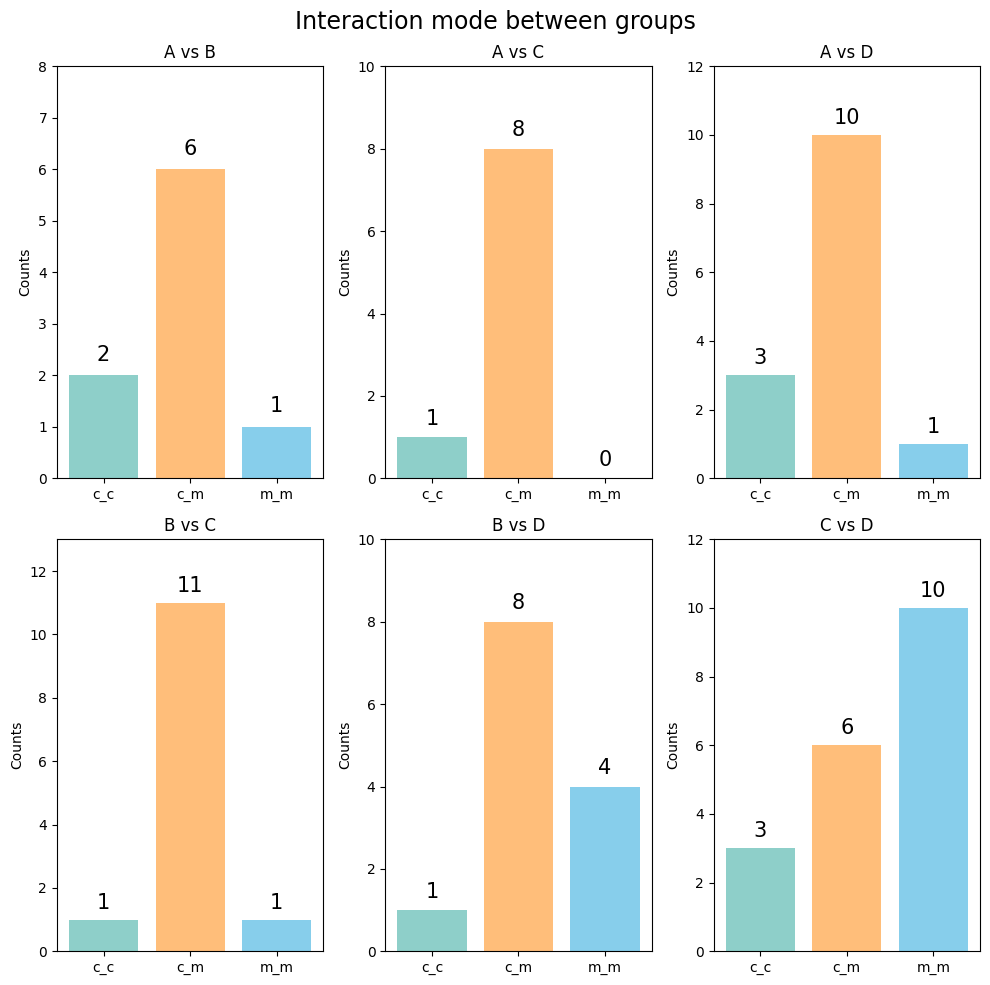

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Softer color palette
colors = ['#8ECFC9', '#FFBE7A', 'skyblue']

# Data for the six comparisons
data = {
    'A vs B': {'c_c': 2, 'c_m': 6, 'm_m': 1},
    'A vs C': {'c_c': 1, 'c_m': 8, 'm_m': 0},
    'A vs D': {'c_c': 3, 'c_m': 10, 'm_m': 1},
    'B vs C': {'c_c': 1, 'c_m': 11, 'm_m': 1},
    'B vs D': {'c_c': 1, 'c_m': 8, 'm_m': 4},
    'C vs D': {'c_c': 3, 'c_m': 6, 'm_m': 10},
}

# Plot each comparison
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
fig.suptitle('Interaction mode between groups', fontsize=17)

# Iterate over data and plot
for i, (comparison, values) in enumerate(data.items()):
    ax = axs[i // 3, i % 3]
    categories = list(values.keys())
    values = list(values.values())
    
    bars = ax.bar(categories, values, color=colors)
    
    # Adding labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.2, int(yval), ha='center', va='bottom', fontsize=15)
    
    ax.set_title(comparison)
    ax.set_ylim(0, max(values) + 2)
    ax.set_ylabel('Counts')

plt.tight_layout()
plt.savefig('../figure/CT/Interaction_mode.pdf', format = 'pdf')
plt.show()

### Node clustering

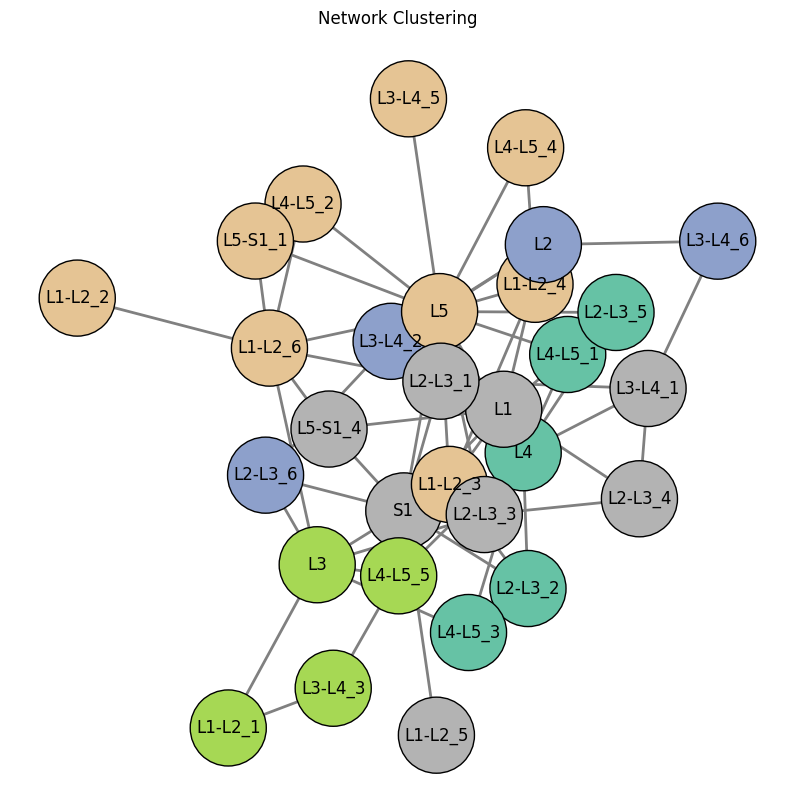

In [178]:
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain
df = pd.read_excel("../data/Interact.xlsx")
G = nx.Graph()
for index, row in df.iterrows():
    node1, node2, edge_type = row
    G.add_node(node1)
    G.add_node(node2)
    G.add_edge(node1, node2, edge_type=edge_type)
partition = community_louvain.best_partition(G)
# Draw the network
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
cmap = plt.get_cmap('Set2')
colors = [cmap(partition[node] / max(partition.values())) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color=colors, edgecolors='black')
nx.draw_networkx_edges(G, pos, edgelist=nx.edges(G), edge_color='gray', width=2)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.title('Network Clustering')
plt.show()

# Save Model

In [ ]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
category = ["A", "B", "C", "D"]
category = list(combinations(category, 2))
meta_model = LogisticRegression(max_iter=10000000)
feature_combinations_ct = [
    ['L4', 'L1-L2_3', 'L2-L3_5', 'L2-L3_6', 'L3-L4_2', 'L4-L5_1'],
    ['L2', 'L4', 'L5', 'L1-L2_2', 'L1-L2_3', 'L1-L2_4', 'L2-L3_3', 'L2-L3_6', 'L4-L5_1', 'L4-L5_2', 'L4-L5_4', 'L5-S1_4'],
    ['L4', 'L5', 'L1-L2_3', 'L3-L4_1', 'L4-L5_3', 'L5-S1_1'],
    ['L1', 'L3', 'L5', 'L1-L2_1', 'L1-L2_2', 'L1-L2_3', 'L1-L2_6', 'L2-L3_3', 'L2-L3_4', 'L2-L3_5', 'L2-L3_6', 'L3-L4_2', 'L4-L5_1', 'L4-L5_2', 'L4-L5_3', 'L4-L5_5'],
    ['L1', 'L5', 'L1-L2_1', 'L1-L2_5', 'L1-L2_6', 'L2-L3_1', 'L2-L3_3', 'L2-L3_6', 'L3-L4_1', 'L3-L4_5', 'L3-L4_6', 'L4-L5_2', 'L5-S1_4'],
    ['L1', 'L2', 'L3', 'L4', 'S1', 'L1-L2_2', 'L1-L2_3', 'L1-L2_4', 'L1-L2_5', 'L1-L2_6', 'L2-L3_2', 'L2-L3_3', 'L2-L3_4', 'L2-L3_6', 'L3-L4_1', 'L3-L4_4', 'L3-L4_6', 'L4-L5_2', 'L4-L5_3', 'L5-S1_1', 'L5-S1_4']
]
model_combination_ct = [
    [
        ('CatBoost',CatBoostClassifier(verbose = False,iterations = 800, max_depth = 5))
    ],
    [
        ('LGBM',LGBMClassifier(verbose = -1,n_estimators = 1000, max_depth = 5)),
        ('CatBoost',CatBoostClassifier(verbose = False,iterations = 800, max_depth = 5))
    ],
    [
        ('CatBoost',CatBoostClassifier(verbose = False,iterations = 800, max_depth = 5))
    ],
    [
        ('CatBoost',CatBoostClassifier(verbose = False,iterations = 800, max_depth = 5))
    ],
    [
        ('LGBM',LGBMClassifier(verbose = -1,n_estimators = 1000, max_depth = 5)),
        ('CatBoost',CatBoostClassifier(verbose = False,iterations = 800, max_depth = 5))
    ],
    [
        ('XGBoost',XGBClassifier(n_estimators = 1000, max_depth = 5)),
        ('CatBoost',CatBoostClassifier(verbose = False,iterations = 800, max_depth = 5))
    ]
]
for i in tqdm(range(len(category))):
    Cat_A = category[i][0]
    Cat_B = category[i][1]
    df = df_all[df_all['Disease'].isin([Cat_A, Cat_B])]
    X = df.drop("Disease",axis = 1)
    X = X[feature_combinations_ct[i]]
    y = df['Disease']
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    shuffle_index = np.random.permutation(X.index)
    X = X.iloc[shuffle_index]
    y = y.iloc[shuffle_index]
    y = y.map({Cat_A: 0, Cat_B: 1})

    base_model = model_combination_ct[i]
    clf = StackingClassifier(estimators=base_model, final_estimator=meta_model, stack_method='predict_proba')
    clf.fit(X,y)
    joblib.dump(clf, f'../model/model_{Cat_A}_vs_{Cat_B}.pkl')

/var/folders/12/n4s7mbz93hsbs7qt91pp0v3w0000gn/T/ipykernel_3270/4241104125.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 6)


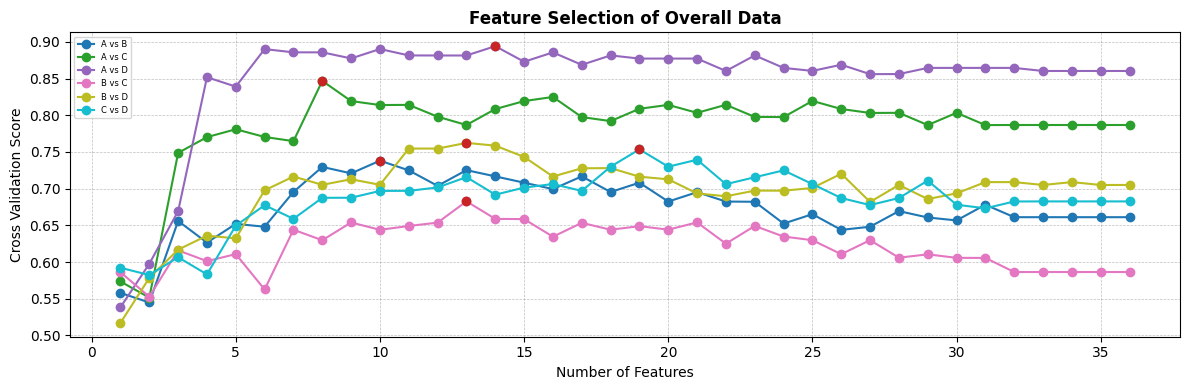

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Data points for each dataset
avsb = [0.5579, 0.5449, 0.6559, 0.6265, 0.6520, 0.6481, 0.6955, 0.7296, 0.7208, 0.7381, 0.7249, 0.7038, 0.7252, 0.7167, 0.7081, 0.6994, 0.7167, 0.6954, 0.7081, 0.6824, 0.6952, 0.6824, 0.6821, 0.6524, 0.6652, 0.6438, 0.6481, 0.6694, 0.6607, 0.6567, 0.6781, 0.6611, 0.6611, 0.6611, 0.6611, 0.6611]
avsc = [0.5735, 0.5515, 0.7487, 0.7702, 0.7809, 0.7704, 0.7647, 0.8468, 0.8193, 0.8139, 0.8141, 0.7980, 0.7867, 0.8084, 0.8193, 0.8249, 0.7975, 0.7920, 0.8088, 0.8141, 0.8033, 0.8142, 0.7977, 0.7975, 0.8195, 0.8085, 0.8031, 0.8033, 0.7866, 0.8033, 0.7866, 0.7867, 0.7867, 0.7867, 0.7867, 0.7867]
avsd = [0.5384, 0.5976, 0.6693, 0.8518, 0.8390, 0.8901, 0.8857, 0.8857, 0.8774, 0.8902, 0.8815, 0.8814, 0.8814, 0.8941, 0.8729, 0.8856, 0.8687, 0.8815, 0.8772, 0.8772, 0.8772, 0.8603, 0.8815, 0.8645, 0.8604, 0.8688, 0.8560, 0.8561, 0.8645, 0.8645, 0.8645, 0.8645, 0.8603, 0.8603, 0.8603, 0.8603]
bvsc = [0.5861, 0.5527, 0.6159, 0.6012, 0.6108, 0.5626, 0.6440, 0.6297, 0.6539, 0.6439, 0.6491, 0.6537, 0.6827, 0.6588, 0.6585, 0.6345, 0.6534, 0.6440, 0.6489, 0.6441, 0.6540, 0.6250, 0.6492, 0.6347, 0.6298, 0.6107, 0.6298, 0.6059, 0.6105, 0.6057, 0.6056, 0.5864, 0.5864, 0.5864, 0.5864, 0.5864]
bvsd = [0.5171, 0.5784, 0.6169, 0.6359, 0.6323, 0.6977, 0.7165, 0.7052, 0.7128, 0.7052, 0.7546, 0.7546, 0.7623, 0.7586, 0.7432, 0.7165, 0.7277, 0.7280, 0.7163, 0.7127, 0.6935, 0.6896, 0.6973, 0.6972, 0.7009, 0.7203, 0.6819, 0.7050, 0.6858, 0.6936, 0.7089, 0.7089, 0.7050, 0.7089, 0.7050, 0.7050]
cvsd = [0.5922, 0.5823, 0.6065, 0.5832, 0.6496, 0.6774, 0.6589, 0.6875, 0.6876, 0.6969, 0.6970, 0.7016, 0.7157, 0.6918, 0.7014, 0.7063, 0.6969, 0.7299, 0.7535, 0.7299, 0.7394, 0.7061, 0.7155, 0.7249, 0.7062, 0.6872, 0.6776, 0.6872, 0.7109, 0.6781, 0.6732, 0.6825, 0.6826, 0.6826, 0.6826, 0.6826]

# X values based on the number of data points
x_values = list(range(len(avsb)))
x_values = [i + 1 for i in x_values]
# Define colors from the Set1 palette
colors = plt.cm.get_cmap('tab10', 6)
# Create the plot
plt.figure(figsize=(12, 4))

# Plot each dataset
plt.plot(x_values, avsb, marker='o', linestyle='-', color=colors(0), label='A vs B')
plt.plot(x_values, avsc, marker='o', linestyle='-', color=colors(1), label='A vs C')
plt.plot(x_values, avsd, marker='o', linestyle='-', color=colors(2), label='A vs D')
plt.plot(x_values, bvsc, marker='o', linestyle='-', color=colors(3), label='B vs C')
plt.plot(x_values, bvsd, marker='o', linestyle='-', color=colors(4), label='B vs D')
plt.plot(x_values, cvsd, marker='o', linestyle='-', color=colors(5), label='C vs D')

def highlight_max(x, y, color='#C82423'):
    max_idx = y.index(max(y))
    plt.plot(x[max_idx], y[max_idx], 'o', color=color)

highlight_max(x_values, avsb)
highlight_max(x_values, avsc)
highlight_max(x_values, avsd)
highlight_max(x_values, bvsc)
highlight_max(x_values, bvsd)
highlight_max(x_values, cvsd)

# Add labels, title, and legend
plt.xlabel('Number of Features')
plt.ylabel('Cross Validation Score')
plt.title('Feature Selection of Overall Data', fontweight='bold')
plt.legend(fontsize=6)
plt.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)

# Optimize layout and show the plot
plt.tight_layout()
plt.savefig('../figure/CT/Feature_Selection.pdf', format = 'pdf')
plt.show()

Group: A, Peak: 67.19, 95% CI: (50.00, 83.00)
Group: B, Peak: 63.17, 95% CI: (52.20, 81.80)
Group: C, Peak: 68.21, 95% CI: (50.95, 84.00)
Group: D, Peak: 73.02, 95% CI: (53.27, 88.45)


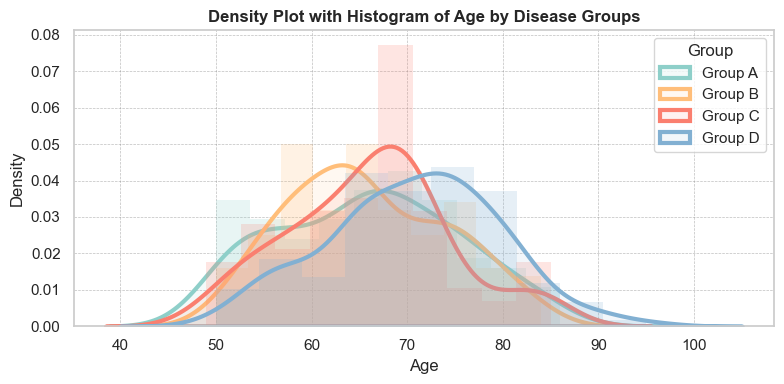

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# 读取 Excel 文件中的数据
data = pd.read_excel('../data/original_data.xlsx')

# 定义函数计算峰值和 95% 置信区间
def peak_and_ci(group_data, ci=95):
    # 计算 KDE
    kde = stats.gaussian_kde(group_data)
    
    # 找到 KDE 的峰值点
    x_range = np.linspace(min(group_data), max(group_data), 1000)
    kde_values = kde(x_range)
    peak_value = x_range[np.argmax(kde_values)]
    
    # 计算 95% 置信区间
    lower_bound = np.percentile(group_data, (100 - ci) / 2)
    upper_bound = np.percentile(group_data, 100 - (100 - ci) / 2)
    
    return peak_value, (lower_bound, upper_bound)

# 创建一个字典来存储每个组的峰值和置信区间
group_peak_ci = {}

# 获取唯一的组
groups = data['Group'].unique()

for group in groups:
    group_data = data[data['Group'] == group]['age']
    peak, (ci_lower, ci_upper) = peak_and_ci(group_data)
    group_peak_ci[group] = {'peak': peak, '95% CI': (ci_lower, ci_upper)}

# 打印每个组的峰值和 95% 置信区间
for group, values in group_peak_ci.items():
    print(f"Group: {group}, Peak: {values['peak']:.2f}, 95% CI: ({values['95% CI'][0]:.2f}, {values['95% CI'][1]:.2f})")

import matplotlib.pyplot as plt
import seaborn as sns

# 设置自定义调色板
custom_palette = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#82B0D2"]

# 创建图形
plt.figure(figsize=(8, 4))

# 绘制每组的 histogram 和 density plot
for group, color in zip(data['Group'].unique(), custom_palette):
    # 绘制 histogram，设置透明度避免和density plot冲突
    sns.histplot(data[data['Group'] == group], x='age', color=color, kde=False, 
                 bins=10, stat="density", alpha=0.2, element="bars", linewidth=0)
    # 绘制 density plot
    sns.kdeplot(data[data['Group'] == group], x='age', color=color, fill=True, 
                alpha=0.1, linewidth=3, label=f'Group {group}')

# 添加图例和标题
plt.title('Density Plot with Histogram of Age by Disease Groups', fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)
plt.legend(title='Group', loc='upper right')
plt.tight_layout()

# 保存和显示图像
plt.savefig("../figure/CT/Age_with_Histogram_and_Density.pdf")
plt.show()

Gender: female, Peak: 66.58, 95% CI: (51.00, 82.00)
Gender: male, Peak: 67.43, 95% CI: (50.00, 86.80)


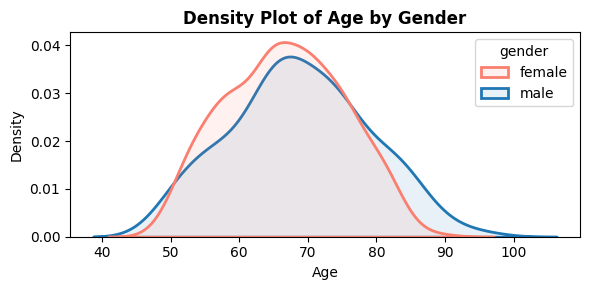

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# 读取 Excel 文件中的数据
data = pd.read_excel('../data/original_data.xlsx')

# 定义函数计算峰值和 95% 置信区间
def peak_and_ci(group_data, ci=95):
    # 计算 KDE
    kde = stats.gaussian_kde(group_data)
    
    # 找到 KDE 的峰值点
    x_range = np.linspace(min(group_data), max(group_data), 1000)
    kde_values = kde(x_range)
    peak_value = x_range[np.argmax(kde_values)]
    
    # 计算 95% 置信区间
    lower_bound = np.percentile(group_data, (100 - ci) / 2)
    upper_bound = np.percentile(group_data, 100 - (100 - ci) / 2)
    
    return peak_value, (lower_bound, upper_bound)

# 创建一个字典来存储每个组的峰值和置信区间
group_peak_ci = {}

# 获取唯一的组
groups = data['gender'].unique()

for group in groups:
    group_data = data[data['gender'] == group]['age']
    peak, (ci_lower, ci_upper) = peak_and_ci(group_data)
    group_peak_ci[group] = {'peak': peak, '95% CI': (ci_lower, ci_upper)}

# 打印每个组的峰值和 95% 置信区间
for group, values in group_peak_ci.items():
    print(f"Gender: {group}, Peak: {values['peak']:.2f}, 95% CI: ({values['95% CI'][0]:.2f}, {values['95% CI'][1]:.2f})")

# 绘制四个组的 age 列 Density Plot
plt.figure(figsize=(6, 3))
# Define your custom color palette
custom_palette = ['#FA7F6F','#1f77b4']
# Plot with custom colors
sns.kdeplot(data=data, x='age', hue='gender', fill=True, common_norm=False, palette=custom_palette, alpha=0.1, linewidth=2)

# 添加图例和标题
plt.title('Density Plot of Age by Gender', fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Density')
plt.tight_layout()

# 保存和显示图像
plt.savefig("../figure/CT/Age_with_gender.pdf")
plt.show()